# pplm_llama

In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]='2'
from evaluate import load
import argparse
import json
from operator import add
from typing import List, Optional, Tuple, Union
import math
import time
import pickle
import numpy as np
import torch
from pplm_classification_head import ClassificationHead
from torch import nn
from tqdm import trange

from transformers import AutoTokenizer, AutoModelForCausalLM,BertTokenizerFast, BertModel
#from transformers.file_utils import cached_path
from cached_path import cached_path

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        #참고로 'bert-base-uncased' 모델은 버트의 가장 기본적인 모델을 의미
        #uncased는 모든 문장을 소문자로 대체하겠다는 것 
        
        self.classifier  = nn.Sequential(
            nn.ReLU(),
            nn.Linear(768,2)
        )
        
        
    def forward(self,inputs):
        
        #print(inputs['input_ids'].shape)  
        bert_outputs = self.bert(**inputs,return_dict =True)
        #print("bert_outputs",bert_outputs)
        pooler_output = bert_outputs.last_hidden_state[:,0]
        # bert_outputs.last_hidden_state[:,0] -> 첫번째니까 [cls] 토큰의
        # embedding만을 뽑아내어 classification task를 위한 텐서로 변환한다? 
        #print("pooler_output",pooler_output.shape)
        
        logits = self.classifier(pooler_output)
        #print("logits",logits.shape)
        
        return logits
PPLM_BOW = 1
PPLM_DISCRIM = 2
PPLM_BOW_DISCRIM = 3
SMALL_CONST = 1e-15
BIG_CONST = 1e10

BAG_OF_WORDS_ARCHIVE_MAP = {
    "legal": "https://s3.amazonaws.com/models.huggingface.co/bert/pplm/bow/legal.txt",
    "military": "https://s3.amazonaws.com/models.huggingface.co/bert/pplm/bow/military.txt",
    "politics": "https://s3.amazonaws.com/models.huggingface.co/bert/pplm/bow/politics.txt",
    "religion": "https://s3.amazonaws.com/models.huggingface.co/bert/pplm/bow/religion.txt",
    "science": "https://s3.amazonaws.com/models.huggingface.co/bert/pplm/bow/science.txt",
    "space": "https://s3.amazonaws.com/models.huggingface.co/bert/pplm/bow/space.txt",
    "technology": "https://s3.amazonaws.com/models.huggingface.co/bert/pplm/bow/technology.txt",
}

DISCRIMINATOR_MODELS_PARAMS = {
    "clickbait": {
        "url": "https://s3.amazonaws.com/models.huggingface.co/bert/pplm/discriminators/clickbait_classifier_head.pt",
        "class_size": 2,
        "embed_size": 1024,
        "class_vocab": {"non_clickbait": 0, "clickbait": 1},
        "default_class": 1,
        "pretrained_model": "llama",
    },
    "sentiment": {
        #"url": "https://s3.amazonaws.com/models.huggingface.co/bert/pplm/discriminators/SST_classifier_head.pt",
        "url": "SST_classifier_head_epoch_9.pt",
        "class_size": 5,
        "embed_size": 4096,
        "class_vocab": {"very_positive": 2, "very_negative": 3},
        "default_class": 3,
        "pretrained_model": "llama",
    },
}

def ngrams(sequence, n, pad_left=False, pad_right=False,
           left_pad_symbol=None, right_pad_symbol=None):
    sequence = pad_sequence(sequence, n, pad_left, pad_right,
                            left_pad_symbol, right_pad_symbol)

    history = []
    while n > 1:
        history.append(next(sequence))
        n -= 1
    for item in sequence:
        history.append(item)
        yield tuple(history)
        del history[0]
def pad_sequence(sequence, n, pad_left=False, pad_right=False,
                 left_pad_symbol=None, right_pad_symbol=None):

    sequence = iter(sequence)
    if pad_left:
        sequence = chain((left_pad_symbol,) * (n - 1), sequence)
    if pad_right:
        sequence = chain(sequence, (right_pad_symbol,) * (n - 1))
    return sequence
def distinct_n_sentence_level(sentence, n):
    if len(sentence) == 0:
        return 0.0  # Prevent a zero division
    distinct_ngrams = set(ngrams(sentence, n))
    return len(distinct_ngrams) / len(sentence)
def distinct_n_corpus_level(sentences, n):
   
    return sum(distinct_n_sentence_level(sentence, n) for sentence in sentences) / len(sentences)
def top_k_filter(logits, k, probs=False):
    """
    Masks everything but the k top entries as -infinity (1e10).
    Used to mask logits such that e^-infinity -> 0 won't contribute to the
    sum of the denominator.
    """
    if k == 0:
        return logits
    else:
        values = torch.topk(logits, k)[0]
        batch_mins = values[:, -1].view(-1, 1).expand_as(logits)
        if probs:
            return torch.where(logits < batch_mins, torch.ones_like(logits) * 0.0, logits)
        return torch.where(logits < batch_mins, torch.ones_like(logits) * -BIG_CONST, logits)
def get_classifier(
    name: Optional[str], class_label: Union[str, int], device: str
) -> Tuple[Optional[ClassificationHead], Optional[int]]:
    if name is None:
        return None, None

    params = DISCRIMINATOR_MODELS_PARAMS[name]
    classifier = ClassificationHead(class_size=params["class_size"], embed_size=params["embed_size"]).to(device)
    if "url" in params:
        resolved_archive_file = cached_path(params["url"])
    elif "path" in params:
        resolved_archive_file = params["path"]
    else:
        raise ValueError("Either url or path have to be specified in the discriminator model parameters")
    classifier.load_state_dict(torch.load(resolved_archive_file, map_location=device))
    classifier.eval()

    if isinstance(class_label, str):
        if class_label in params["class_vocab"]:
            label_id = params["class_vocab"][class_label]
        else:
            label_id = params["default_class"]
            print("class_label {} not in class_vocab".format(class_label))
            print("available values are: {}".format(params["class_vocab"]))
            print("using default class {}".format(label_id))

    elif isinstance(class_label, int):
        if class_label in set(params["class_vocab"].values()):
            label_id = class_label
        else:
            label_id = params["default_class"]
            print("class_label {} not in class_vocab".format(class_label))
            print("available values are: {}".format(params["class_vocab"]))
            print("using default class {}".format(label_id))

    else:
        label_id = params["default_class"]

    return classifier, label_id


def get_bag_of_words_indices(bag_of_words_ids_or_paths: List[str], tokenizer) -> List[List[List[int]]]:
    bow_indices = []
    for id_or_path in bag_of_words_ids_or_paths:
        if id_or_path in BAG_OF_WORDS_ARCHIVE_MAP:
            filepath = cached_path(BAG_OF_WORDS_ARCHIVE_MAP[id_or_path])
        else:
            filepath = id_or_path
        with open(filepath, "r") as f:
            words = f.read().strip().split("\n")
        bow_indices.append([tokenizer.encode(word.strip(), add_prefix_space=True) for word in words])
    return bow_indices


def build_bows_one_hot_vectors(bow_indices, tokenizer, device="cuda"):
    if bow_indices is None:
        return None

    one_hot_bows_vectors = []
    for single_bow in bow_indices:
        single_bow = list(filter(lambda x: len(x) <= 1, single_bow))
        single_bow = torch.tensor(single_bow).to(device)
        num_words = single_bow.shape[0]
        one_hot_bow = torch.zeros(num_words, tokenizer.vocab_size).to(device)
        one_hot_bow.scatter_(1, single_bow, 1)
        one_hot_bows_vectors.append(one_hot_bow)
    return one_hot_bows_vectors

<frozen importlib._bootstrap>:219: RuntimeWarning: pyarrow._fs.FileInfo size changed, may indicate binary incompatibility. Expected 64 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: pyarrow._fs.FileSelector size changed, may indicate binary incompatibility. Expected 48 from C header, got 72 from PyObject



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: CUDA runtime path found: /home/wooseok/miniconda3/envs/mh/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 6.1
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /home/wooseok/miniconda3/envs/mh/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda113_nocublaslt.so...


/home/wooseok/miniconda3/envs/mh/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: Compute capability < 7.5 detected! Only slow 8-bit matmul is supported for your GPU!
  warn(msg)


In [2]:
seed= 0 
no_cuda = False
discrim = 'sentiment'
uncond = False
cond_text = 'I am studying'
num_samples = 2
bag_of_words = None
class_label = 2
length = 5
stepsize = 0.04
temperature = 1.0
top_k = 10
sample = True
num_iterations= 1
grad_length = 10000
horizon_length = 1
window_length = 0
decay = False
gamma = 1.0
gm_scale = 0.95
kl_scale = 0.01
repetition_penalty = 1.0
perturb_layer = 100
bow_indices = None
one_hot_bows_vectors = None

In [3]:
(781+774+548+365)/4

617.0

# 1. run_pplm_example

In [4]:
torch.manual_seed(seed)
np.random.seed(seed)

# set the device
device = "cuda" if torch.cuda.is_available() and not no_cuda else "cpu"

pretrained_model = DISCRIMINATOR_MODELS_PARAMS[discrim]["pretrained_model"]
print("discrim = {}, pretrained_model set to discriminator's = {}".format(discrim, pretrained_model))


model = AutoModelForCausalLM.from_pretrained("/home/wooseok/llama-7b-hf",
                                             device_map="auto",
                                             load_in_8bit=True)
model.eval()


discrim = sentiment, pretrained_model set to discriminator's = llama


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=31999)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): Llama

In [6]:

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/wooseok/llama-7b-hf",
                                          unk_token="<unk>",
                                                    bos_token="<s>",
                                                    #eos_token="</s>"
                                         )
# Freeze llama weights
for param in model.parameters():
    param.requires_grad = False

# figure out conditioning text
cond_text = "The movie was"
raw_text = cond_text
tokenized_cond_text = tokenizer.encode(raw_text)

context = tokenized_cond_text

print("= Prefix of sentence =")
print(tokenizer.decode(tokenized_cond_text))
print()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


= Prefix of sentence =
<s> The movie was



# 2.Full_text_generation

In [7]:
classifier, class_id = get_classifier(discrim, class_label, device)
print(classifier)

ClassificationHead(
  (mlp): Linear(in_features=4096, out_features=5, bias=True)
)


In [8]:
loss_type = PPLM_DISCRIM

## 2.1 섭동 안줄 때 

In [11]:
def generate_text_pplm(
    model,
    tokenizer,
    context=None,
    past=None,
    device="cuda",
    perturb=True,
    bow_indices=None,
    classifier=None,
    class_label=None,
    loss_type=0,
    length=100,
    stepsize=0.02,
    temperature=1.0,
    top_k=10,
    sample=False,
    num_iterations=3,
    grad_length=10000,
    horizon_length=1,
    window_length=0,
    decay=False,
    gamma=1.5,
    gm_scale=0.9,
    kl_scale=0.01,
    repetition_penalty=1.0,
    perturb_layer = 100,
):
    output_so_far = None
    if context:
        context_t = torch.tensor(context, device=device, dtype=torch.long)
        while len(context_t.shape) < 2:
            context_t = context_t.unsqueeze(0)
        output_so_far = context_t # tensor([[    1,   306,   626, 23382]], device='cuda:0')
        
    grad_norms = None
    last = None
    unpert_discrim_loss = 0
    loss_in_time = []
    for i in trange(length, ascii=True):
        # Get past/probs for current output, except for last word
        # Note that GPT takes 2 inputs: past + current_token

        # run model forward to obtain unperturbed
        if past is None and output_so_far is not None:
            last = output_so_far[:, -1:]
            if output_so_far.shape[1] > 1:
            
                
                past = model(output_so_far[:, :-1],return_dict =True)["past_key_values"]
                #print(len(past))
                #print(len(past[0]))
                #print(past[0][0].sha)

        lm_output = model(output_so_far,return_dict =True,output_hidden_states=True)
        unpert_logits, unpert_past, unpert_all_hidden = (
            lm_output["logits"],
            lm_output["past_key_values"],
            lm_output["hidden_states"],
        )
        unpert_last_hidden = unpert_all_hidden[-1]

        # check if we are abowe grad max length
        if i >= grad_length:
            current_stepsize = stepsize * 0
        else:
            current_stepsize = stepsize

        # modify the past if necessary
        if not perturb or num_iterations == 0:
            pert_past = past
        else:
            accumulated_hidden = unpert_last_hidden[:, :-1, :]
            accumulated_hidden = torch.sum(accumulated_hidden, dim=1)

            if past is not None:
                pert_past, _, grad_norms, loss_this_iter = perturb_past(
                    past,
                    model,
                    last,
                    unpert_past=unpert_past,
                    unpert_logits=unpert_logits,
                    accumulated_hidden=accumulated_hidden,
                    grad_norms=grad_norms,
                    stepsize=current_stepsize,
                    one_hot_bows_vectors=one_hot_bows_vectors,
                    classifier=classifier,
                    class_label=class_label,
                    loss_type=loss_type,
                    num_iterations=num_iterations,
                    horizon_length=horizon_length,
                    window_length=window_length,
                    decay=decay,
                    gamma=gamma,
                    kl_scale=kl_scale,
                    perturb_layer = perturb_layer,
                    device=device,
                )
                loss_in_time.append(loss_this_iter)
            else:
                pert_past = past
        ######## past type 맞춰주기
        qqqq= []
        for i in range(len(pert_past)):
            qqqq.append(torch.stack([pert_past[i][0],pert_past[i][1]]))
        pert_past = qqqq
        for i in range(len(pert_past)):
            pert_past[i] = pert_past[i].to(torch.float16)
        ######## past type 맞춰주기 끝 
        
        lm_output = model(last, past_key_values=pert_past,return_dict =True,output_hidden_states=True)
        pert_logits, past = (
            lm_output["logits"],
            lm_output["past_key_values"],
        )
        
        pert_logits = pert_logits[:, -1, :] / temperature  # + SMALL_CONST

        for token_idx in set(output_so_far[0].tolist()):
            if pert_logits[0, token_idx] < 0:
                pert_logits[0, token_idx] *= repetition_penalty
            else:
                pert_logits[0, token_idx] /= repetition_penalty

        pert_probs = nn.functional.softmax(pert_logits, dim=-1)

        if classifier is not None:
            ce_loss = nn.CrossEntropyLoss()
            prediction = classifier(torch.mean(unpert_last_hidden, dim=1))
            label = torch.tensor([class_label], device=device, dtype=torch.long)
            unpert_discrim_loss = ce_loss(prediction, label)
            print("unperturbed discrim loss", unpert_discrim_loss.data.cpu().numpy())
        else:
            unpert_discrim_loss = 0

        # Fuse the modified model and original model
        if perturb:
            unpert_probs = nn.functional.softmax(unpert_logits[:, -1, :], dim=-1)

            pert_probs = (pert_probs**gm_scale) * (unpert_probs ** (1 - gm_scale))  # + SMALL_CONST
            pert_probs = top_k_filter(pert_probs, k=top_k, probs=True)  # + SMALL_CONST

            # rescale
            if torch.sum(pert_probs) <= 1:
                pert_probs = pert_probs / torch.sum(pert_probs)

        else:
            pert_logits = top_k_filter(pert_logits, k=top_k)  # + SMALL_CONST
            pert_probs = nn.functional.softmax(pert_logits, dim=-1)

        # sample or greedy
        if sample:
            last = torch.multinomial(pert_probs, num_samples=1)

        else:
            _, last = torch.topk(pert_probs, k=1, dim=-1)

        # update context/output_so_far appending the new token
        output_so_far = last if output_so_far is None else torch.cat((output_so_far, last), dim=1)

        print(tokenizer.decode(output_so_far.tolist()[0]))

    return output_so_far, unpert_discrim_loss, loss_in_time

In [12]:
unpert_gen_tok_text, _, _ = generate_text_pplm(
        model=model,
        tokenizer=tokenizer,
        context=context,
        device=device,
        length=length,
        sample=sample,
        perturb=False,
        repetition_penalty=repetition_penalty,
    )

 20%|#################                                                                    | 1/5 [00:04<00:16,  4.11s/it]

<s> The movie was directed


 40%|##################################                                                   | 2/5 [00:05<00:06,  2.24s/it]

<s> The movie was directed by


 60%|###################################################                                  | 3/5 [00:07<00:04,  2.12s/it]

<s> The movie was directed by Raj


 80%|####################################################################                 | 4/5 [00:09<00:02,  2.08s/it]

<s> The movie was directed by Rajk


100%|#####################################################################################| 5/5 [00:10<00:00,  2.19s/it]

<s> The movie was directed by Rajkumar


In [10]:
context

[1, 450, 14064, 471]

In [14]:
cond_text = 'The movie was'

raw_text = cond_text
tokenized_cond_text = tokenizer.encode(raw_text)

context = tokenized_cond_text

output_so_far = None
past = None
perturb=False
if context:
    context_t = torch.tensor(context, device=device, dtype=torch.long)
    while len(context_t.shape) < 2:
        context_t = context_t.unsqueeze(0)
    output_so_far = context_t # tensor([[    1,   306,   626, 23382]], device='cuda:0')
output_so_far

tensor([[    1,   450, 14064,   471]], device='cuda:0')

In [15]:
output_so_far

tensor([[    1,   450, 14064,   471]], device='cuda:0')

In [16]:
lm_output= model(output_so_far
                 ,return_dict=True,output_hidden_states=True)

print(lm_output.keys())

odict_keys(['logits', 'past_key_values', 'hidden_states'])


In [17]:
lm_output= model(output_so_far
                 ,return_dict=True,output_hidden_states=True)

logit = lm_output["logits"] 
# torch.Size([1, 4, 32000])
# batch_size, sequence_length, vocab_size

In [18]:
probs = nn.functional.softmax(logit[:,-1,:], dim=-1)
last = torch.topk(probs, k=1, dim=-1)[1]
output_so_far =torch.cat((output_so_far, last), dim=1)
print(output_so_far)

tensor([[    1,   450, 14064,   471,  5492]], device='cuda:0')


In [19]:
lm_output= model(output_so_far
                 ,return_dict=True,output_hidden_states=True)

past = lm_output["past_key_values"]
# 32, 2, torch.Size([1, 32,4, 128])
# layer 수, key_value 2개,(batch_size, num_heads, sequence_length, embed_size_per_head)

hidden_states = lm_output["hidden_states"]
# 33, torch.Size([1, 4, 4096])
# layer수+1, (batch_size, sequence_length, hidden_size)

In [20]:
lm_output= model(output_so_far
                 ,return_dict=True,output_hidden_states=True)

hidden_states = lm_output["hidden_states"]
# 33, torch.Size([1, 4, 4096])
# layer수+1, (batch_size, sequence_length, hidden_size)

In [21]:
lm_output= model(output_so_far
                 ,return_dict=True,output_hidden_states=True)

logit, past, hidden_states= (
    lm_output["logits"], 
    # torch.Size([1, 4, 32000])
    # batch_size, sequence_length, vocab_size
    
    lm_output["past_key_values"],
    # 32, 2, torch.Size([1, 32,4, 128])
    # layer 수, key_value 2개,(batch_size, num_heads, sequence_length, embed_size_per_head)
    
    lm_output["hidden_states"])
    # 33, torch.Size([1, 4, 4096])
    # layer수+1, (batch_size, sequence_length, hidden_size)

print(logit.shape)
print(len(past),len(past[0]),past[0][0].shape)    
print(len(hidden_states),hidden_states[0].shape)    
    
probs = nn.functional.softmax(logit[:,-1,:], dim=-1)
last = torch.topk(probs, k=1, dim=-1)[1]
output_so_far =torch.cat((output_so_far, last), dim=1)
print(output_so_far)


torch.Size([1, 5, 32000])
32 2 torch.Size([1, 32, 5, 128])
33 torch.Size([1, 5, 4096])
tensor([[    1,   450, 14064,   471,  5492,   297]], device='cuda:0')


In [22]:
print(tokenizer.decode(output_so_far.tolist()[0]))

<s> The movie was released in


In [23]:
probs = nn.functional.softmax(logit[:,-1,:], dim=-1)
last = torch.topk(probs, k=1, dim=-1)[1]
output_so_far =torch.cat((output_so_far, last), dim=1)
print(tokenizer.decode(output_so_far.tolist()[0]))

<s> The movie was released in in


In [24]:
cond_text = 'The movie was'

raw_text = cond_text
tokenized_cond_text = tokenizer.encode(tokenizer.bos_token + raw_text)

context = tokenized_cond_text

output_so_far = None
past = None
perturb=False
if context:
    context_t = torch.tensor(context, device=device, dtype=torch.long)
    while len(context_t.shape) < 2:
        context_t = context_t.unsqueeze(0)
    output_so_far = context_t # tensor([[    1,   306,   626, 23382]], device='cuda:0')
output_so_far

tensor([[    1,     1,   450, 14064,   471]], device='cuda:0')

In [25]:
last = output_so_far[:, -1:] # 마지막 단어
past = model(output_so_far[:, :-1],return_dict =True)["past_key_values"] #이전단어들의 key_value

In [26]:
lm_output= model(last, past_key_values=past,
                 return_dict=True,output_hidden_states=True)  
logit, past = (
    lm_output["logits"], 
    # torch.Size([1, 1, 32000]
    
    lm_output["past_key_values"]) 
    # 32, 2, torch.Size([1, 32, Sequence_len, 128]) )
probs = nn.functional.softmax(logit[:,-1,:], dim=-1)
last = torch.topk(probs, k=1, dim=-1)[1]

In [27]:
print(logit.shape)
print(len(past),len(past[0]),past[0][0].shape)

torch.Size([1, 1, 32000])
32 2 torch.Size([1, 32, 5, 128])


In [28]:
pert_past = perturb_past()

NameError: name 'perturb_past' is not defined

In [ ]:
# 마지막 단어와,past를 input으로 넣음.

In [29]:
probs = nn.functional.softmax(logit[:,-1,:], dim=-1)
last = torch.topk(probs, k=1, dim=-1)[1]

output_so_far =torch.cat((output_so_far, last), dim=1)

In [30]:
output_so_far =torch.cat((output_so_far, last), dim=1)

In [31]:
output_so_far.shape

torch.Size([1, 7])

In [32]:
print(logit.shape)
print(len(past),len(past[0]),past[0][0].shape)

torch.Size([1, 1, 32000])
32 2 torch.Size([1, 32, 5, 128])


In [33]:
print(tokenizer.decode(output_so_far.tolist()[0]))

<s><s> The movie was released released


In [34]:
output_so_far

tensor([[    1,     1,   450, 14064,   471,  5492,  5492]], device='cuda:0')

In [35]:
print(len(hidden_states),hidden_states[0].shape)

33 torch.Size([1, 5, 4096])


In [36]:
hidden_states[0].shape

torch.Size([1, 5, 4096])

In [37]:
a_probs.shape

NameError: name 'a_probs' is not defined

In [38]:
32*128

4096

In [39]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=31999)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): Llama

In [27]:
a_past[0][0] == b_past[0][0]

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         ...,

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
     

In [41]:
output_so_far[:, :-1]

tensor([[    1,   306,   626, 23382]], device='cuda:0')

In [61]:
len(model(output_so_far[:, :-1],return_dict =True)['logits']),model(output_so_far[:, :-1],return_dict =True)['logits'][0].shape
#(batch_size, sequence_length, config.vocab_size)

(1, torch.Size([4, 32000]))

In [84]:
output_so_far

tensor([[    1,   306,   626, 23382,  4223,  5449,  1535,  1363,   372]],
       device='cuda:0')

In [83]:
model(output_so_far).keys()

odict_keys(['logits', 'past_key_values'])

In [77]:
model(output_so_far,return_dict =True,output_hidden_states=True).keys()

odict_keys(['logits', 'past_key_values', 'hidden_states'])

In [82]:
model(last, past_key_values=pert_past,return_dict =True,output_hidden_states=True).keys()

odict_keys(['logits', 'past_key_values', 'hidden_states'])

In [85]:
last

tensor([[372]], device='cuda:0')

In [88]:
context

[1, 306, 626, 23382]

In [40]:
cond_text = 'I am studying'

raw_text = cond_text
tokenized_cond_text = tokenizer.encode(tokenizer.bos_token + raw_text)

context = tokenized_cond_text

output_so_far = None
past = None
perturb=False
if context:
    context_t = torch.tensor(context, device=device, dtype=torch.long)
    while len(context_t.shape) < 2:
        context_t = context_t.unsqueeze(0)
    output_so_far = context_t # tensor([[    1,   306,   626, 23382]], device='cuda:0')

grad_norms = None
last = None
unpert_discrim_loss = 0
loss_in_time = []
for i in trange(length, ascii=True):
    
    # Get past/probs for current output, except for last word
    # Note that GPT takes 2 inputs: past + current_token

    # run model forward to obtain unperturbed
    if past is None and output_so_far is not None: # 제일 처음에만 얘한테 걸림. 
        
        last = output_so_far[:, -1:] # 마지막 단어
        if output_so_far.shape[1] > 1:
            past = model(output_so_far[:, :-1],return_dict =True)["past_key_values"] # 이전 단어들을 input으로 넣어서 첫 past 만듬. 
            #print(len(past),len(past[0]),past[0][0].shape) #layer수,keyvalue, torch.Size([1, 32, 3, 128]) (batch_size, num_heads, sequence_length, embed_size_per_head)

    lm_output = model(output_so_far,return_dict =True,output_hidden_states=True)
    unpert_logits, unpert_past, unpert_all_hidden = (
        lm_output["logits"], #Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax). #(batch_size, sequence_length, vocab_size)
        lm_output["past_key_values"], # #layer수,keyvalue, (batch_size, num_heads, sequence_length, embed_size_per_head(key 벡터의 길이))
        lm_output["hidden_states"], #layer 수, (batch_size, sequence_length, hidden_size(sequence를 이 벡터 길이만큼 표현하겠다)).
    )
    #print(unpert_logits.shape) #(batch_size, sequence_length, config.vocab_size)
    #print(len(unpert_past),len(unpert_past[0]),unpert_past[0][0].shape)
    print(len(unpert_all_hidden),unpert_all_hidden[0].shape) #33 torch.Size([1, 4, 4096])
    unpert_last_hidden = unpert_all_hidden[-1]
    #print(unpert_last_hidden.shape)
   
    current_stepsize = stepsize

    # modify the past if necessary
    if not perturb or num_iterations == 0:
        pert_past = past
    '''
    ####################################### perturb 하는 부분 #################################
    else:
            accumulated_hidden = unpert_last_hidden[:, :-1, :]
            accumulated_hidden = torch.sum(accumulated_hidden, dim=1)

            if past is not None:
                pert_past, _, grad_norms, loss_this_iter = perturb_past(
                    past,
                    model,
                    last,
                    unpert_past=unpert_past,
                    unpert_logits=unpert_logits,
                    accumulated_hidden=accumulated_hidden,
                    grad_norms=grad_norms,
                    stepsize=current_stepsize,
                    one_hot_bows_vectors=one_hot_bows_vectors,
                    classifier=classifier,
                    class_label=class_label,
                    loss_type=loss_type,
                    num_iterations=num_iterations,
                    horizon_length=horizon_length,
                    window_length=window_length,
                    decay=decay,
                    gamma=gamma,
                    kl_scale=kl_scale,
                    perturb_layer = perturb_layer,
                    device=device,
                )
                loss_in_time.append(loss_this_iter)
            else:
                pert_past = past         
    ####################################### perturb 하는 부분 끝 #################################
    '''
    ''' past type 맞춰주기'''
    qqqq= []
    for i in range(len(pert_past)):
        qqqq.append(torch.stack([pert_past[i][0],pert_past[i][1]]))
    pert_past = qqqq
    for i in range(len(pert_past)):
        pert_past[i] = pert_past[i].to(torch.float16)
    '''past type 맞춰주기 끝''' 
    
    print(last)
    lm_output = model(last, past_key_values=pert_past,return_dict =True,output_hidden_states=True) # 마지막 단어와,past를 input으로 넣음. 
    pert_logits, past = (
        lm_output["logits"], # torch.Size([1, 1, 32000])
        lm_output["past_key_values"],
    )
    #print(pert_logits.shape) #(batch_size, sequence_length=1, config.vocab_size)
    #print(len(past),len(past[0]),past[0][0].shape)
    
    ''' temperatute_scailing, repetition_penalty으로 pert_logits 건드리기'''
    pert_logits = pert_logits[:, -1, :] / temperature  # + SMALL_CONST
    #print(pert_logits.shape) # torch.Size([1, 32000])
    #print(output_so_far[0])
    for token_idx in set(output_so_far[0].tolist()):
        if pert_logits[0, token_idx] < 0:
            pert_logits[0, token_idx] *= repetition_penalty
        else:
            pert_logits[0, token_idx] /= repetition_penalty
    ''' temperatute_scailing, repetition_penalty 끝'''
    
    pert_probs = nn.functional.softmax(pert_logits, dim=-1)
    
    if classifier is not None:
        ce_loss = nn.CrossEntropyLoss()
        prediction = classifier(torch.mean(unpert_last_hidden, dim=1))
        label = torch.tensor([class_label], device=device, dtype=torch.long)
        unpert_discrim_loss = ce_loss(prediction, label)
        print("unperturbed discrim loss", unpert_discrim_loss.data.cpu().numpy())
    else:
        unpert_discrim_loss = 0

    # Fuse the modified model and original model
    if perturb: 
        unpert_probs = nn.functional.softmax(unpert_logits[:, -1, :], dim=-1)

        pert_probs = (pert_probs**gm_scale) * (unpert_probs ** (1 - gm_scale))  # + SMALL_CONST
        pert_probs = top_k_filter(pert_probs, k=top_k, probs=True)  # + SMALL_CONST

        # rescale
        if torch.sum(pert_probs) <= 1:
            pert_probs = pert_probs / torch.sum(pert_probs)
    else:
        pert_logits = top_k_filter(pert_logits, k=top_k)  # + SMALL_CONST
        print(pert_logits.shape,"zzz")
        pert_probs = nn.functional.softmax(pert_logits, dim=-1)
        
    # sample or greedy
    if sample:
        last = torch.multinomial(pert_probs, num_samples=1)

    else:
        _, last = torch.topk(pert_probs, k=1, dim=-1)

    # update context/output_so_far appending the new token
    output_so_far = last if output_so_far is None else torch.cat((output_so_far, last), dim=1)

    print(tokenizer.decode(output_so_far.tolist()[0]))

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]

33 torch.Size([1, 5, 4096])
tensor([[23382]], device='cuda:0')


 20%|#################                                                                    | 1/5 [00:03<00:14,  3.53s/it]

unperturbed discrim loss 5.120018
torch.Size([1, 32000]) zzz
<s><s> I am studying how
33 torch.Size([1, 6, 4096])
tensor([[920]], device='cuda:0')


 40%|##################################                                                   | 2/5 [00:05<00:08,  2.83s/it]

unperturbed discrim loss 4.457481
torch.Size([1, 32000]) zzz
<s><s> I am studying how the
33 torch.Size([1, 7, 4096])
tensor([[278]], device='cuda:0')


 60%|###################################################                                  | 3/5 [00:07<00:04,  2.28s/it]

unperturbed discrim loss 3.8468409
torch.Size([1, 32000]) zzz
<s><s> I am studying how the different
33 torch.Size([1, 8, 4096])
tensor([[1422]], device='cuda:0')


 80%|####################################################################                 | 4/5 [00:08<00:01,  1.84s/it]

unperturbed discrim loss 3.5742111
torch.Size([1, 32000]) zzz
<s><s> I am studying how the different parts
33 torch.Size([1, 9, 4096])
tensor([[5633]], device='cuda:0')


100%|#####################################################################################| 5/5 [00:09<00:00,  1.93s/it]

unperturbed discrim loss 3.708449
torch.Size([1, 32000]) zzz
<s><s> I am studying how the different parts of


In [3]:
device = "cuda" if torch.cuda.is_available() and not no_cuda else "cpu"

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained("/home/wooseok/llama-7b-hf", 
                                             device_map="auto", load_in_8bit=True)
tokenizer = AutoTokenizer.from_pretrained("/home/wooseok/llama-7b-hf")

cond_text = 'The movie was'
output_so_far = torch.tensor(tokenizer.encode(tokenizer.bos_token + cond_text),
                             device=device, dtype=torch.long).unsqueeze(0)

/home/wooseok/miniconda3/envs/mh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.
/home/wooseok/miniconda3/envs/mh/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: Compute capability < 7.5 detected! Only slow 8-bit matmul is supported for your GPU!
  warn(msg)



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: CUDA runtime path found: /home/wooseok/miniconda3/envs/mh/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 6.1
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /home/wooseok/miniconda3/envs/mh/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda113_nocublaslt.so...


Loading checkpoint shards: 100%|████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│   4 tokenizer = AutoTokenizer.from_pretrained("/home/wooseok/llama-7b-hf")                       │
│   5                                                                                              │
│   6 cond_text = 'The movie was'                                                                  │
│ ❱ 7 output_so_far = torch.tensor(tokenizer.encode(tokenizer.bos_token + cond_text),              │
│   8 │   │   │   │   │   │   │    device=device, dtype=torch.long).unsqueeze(0)                   │
│   9                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'torch' is not defined

In [3]:
tokenizer.encode(tokenizer.bos_token + cond_text),
                             device=device, dtype=torch.long)

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│                              device=device, dtype=torch.long)                                    │
│                             ▲                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndentationError: unexpected indent

In [9]:
device
cond_text = 'The movie was'
output_so_far = torch.tensor(tokenizer.encode(tokenizer.bos_token + cond_text),
                             device=device, dtype=torch.long).unsqueeze(0)

In [10]:
output_so_far = torch.tensor(tokenizer.encode(tokenizer.bos_token + cond_text),
                             device=device).unsqueeze(0)

In [11]:
print(output_so_far)

tensor([[    1,   450, 14064,   471]], device='cuda:0')


In [12]:
output_so_far

tensor([[    1,   450, 14064,   471]], device='cuda:0')

In [13]:
last = output_so_far[:, -1:] # 마지막 단어 # tensor([[23382]], device='cuda:0')

# 시작할 때 이전단어들로 past 만들어주기
past = model(output_so_far[:, :-1],return_dict =True)["past_key_values"] # 이전 단어들을 input으로 넣어서 첫 past 만듬.

In [14]:
print(model(output_so_far[:, :-1],return_dict =True).keys())

odict_keys(['logits', 'past_key_values'])


In [15]:
last = output_so_far[:, -1:]
past = model(output_so_far[:, :-1],return_dict =True)["past_key_values"]

In [16]:
print(len(past),",",len(past[0]),",",past[0][0].shape) 
#layer수,key_value, torch.Size([batch_size, num_heads, sequence_length, embed_size_per_head]) 

32 , 2 , torch.Size([1, 32, 3, 128])


In [17]:
last

tensor([[471]], device='cuda:0')

In [18]:
output_so_far[:, :-1]

tensor([[    1,   450, 14064]], device='cuda:0')

In [19]:
classifier

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 classifier                                                                                   │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'classifier' is not defined

In [20]:
# 마지막 단어와, past_key_values 를 넣어서 , logit과 다음 past를 output. 
lm_output = model(last, past_key_values=past, return_dict =True,output_hidden_states=True)
logits, past,hidden_states = (
        lm_output["logits"], # torch.Size([1, 1, 32000])
        lm_output["past_key_values"], 
        lm_output["hidden_states"]) # 33, torch.Size([1, 1, 4096]


In [21]:
last_hidden_states = hidden_states[-1]
len(last_hidden_states),last_hidden_states[0].shape 

(1, torch.Size([1, 4096]))

In [22]:
logits, past = (
        lm_output["logits"], # torch.Size([1, 1, 32000])
        lm_output["past_key_values"],
    )

In [23]:
print(logits.shape) #(batch_size, sequence_length=1, config.vocab_size)
print(len(past),len(past[0]),past[0][0].shape) #layer수,keyvalue, torch.Size([1, 32, 3, 128]) (batch_size, num_heads, sequence_length, embed_size_per_head)


torch.Size([1, 1, 32000])
32 2 torch.Size([1, 32, 4, 128])


In [24]:

''' temperatute_scailing, repetition_penalty으로 pert_logits 건드리기'''
pert_logits = logits[:, -1, :] / temperature  # + SMALL_CONST
#print(pert_logits.shape) # torch.Size([1, 32000])
#print(output_so_far[0])
for token_idx in set(output_so_far[0].tolist()):
    if pert_logits[0, token_idx] < 0:
        pert_logits[0, token_idx] *= repetition_penalty
    else:
        pert_logits[0, token_idx] /= repetition_penalty
''' temperatute_scailing, repetition_penalty 끝'''

logits = top_k_filter(pert_logits, k=top_k)  # + SMALL_CONST
probs = nn.functional.softmax(logits, dim=-1)

In [25]:
print(logits.shape) #(batch_size, sequence_length=1, config.vocab_size)

torch.Size([1, 32000])


In [26]:
print(probs.shape)

torch.Size([1, 32000])


In [27]:
# sample or greedy
if sample:
    last = torch.multinomial(probs, num_samples=1)
else:
    _, last = torch.topk(probs, k=1, dim=-1)

In [28]:
last = torch.topk(probs, k=1, dim=-1)[1]

In [29]:
last

tensor([[263]], device='cuda:0')

In [30]:
output_so_far = torch.cat((output_so_far, last), dim=1)

print(tokenizer.decode(output_so_far.tolist()[0]))

 The movie was a


In [31]:
lm_output = model(last, past_key_values=past, return_dict =True,output_hidden_states=True)
logits, past = (
        lm_output["logits"], # torch.Size([1, 1, 32000])
        lm_output["past_key_values"],
    )
pert_logits = logits[:, -1, :] / temperature  # + SMALL_CONST
#print(pert_logits.shape) # torch.Size([1, 32000])
#print(output_so_far[0])
for token_idx in set(output_so_far[0].tolist()):
    if pert_logits[0, token_idx] < 0:
        pert_logits[0, token_idx] *= repetition_penalty
    else:
        pert_logits[0, token_idx] /= repetition_penalty
''' temperatute_scailing, repetition_penalty 끝'''

logits = top_k_filter(pert_logits, k=top_k)  # + SMALL_CONST
probs = nn.functional.softmax(logits, dim=-1)
if sample:
    last = torch.multinomial(probs, num_samples=1)
else:
    _, last = torch.topk(probs, k=1, dim=-1)
output_so_far = torch.cat((output_so_far, last), dim=1)

print(tokenizer.decode(output_so_far.tolist()[0]))

 The movie was a bit


In [32]:
lm_output = model(last, past_key_values=past, return_dict =True,output_hidden_states=True)
logits, past = (
        lm_output["logits"], # torch.Size([1, 1, 32000])
        lm_output["past_key_values"],
    )
pert_logits = logits[:, -1, :] / temperature  # + SMALL_CONST
#print(pert_logits.shape) # torch.Size([1, 32000])
#print(output_so_far[0])
for token_idx in set(output_so_far[0].tolist()):
    if pert_logits[0, token_idx] < 0:
        pert_logits[0, token_idx] *= repetition_penalty
    else:
        pert_logits[0, token_idx] /= repetition_penalty
''' temperatute_scailing, repetition_penalty 끝'''

logits = top_k_filter(pert_logits, k=top_k)  # + SMALL_CONST
probs = nn.functional.softmax(logits, dim=-1)
if sample:
    last = torch.multinomial(probs, num_samples=1)
else:
    _, last = torch.topk(probs, k=1, dim=-1)
output_so_far = torch.cat((output_so_far, last), dim=1)

print(tokenizer.decode(output_so_far.tolist()[0]))

 The movie was a bit more


In [33]:
lm_output = model(last, past_key_values=past, return_dict =True,output_hidden_states=True)
logits, past = (
        lm_output["logits"], # torch.Size([1, 1, 32000])
        lm_output["past_key_values"],
    )
pert_logits = logits[:, -1, :] / temperature  # + SMALL_CONST
#print(pert_logits.shape) # torch.Size([1, 32000])
#print(output_so_far[0])
for token_idx in set(output_so_far[0].tolist()):
    if pert_logits[0, token_idx] < 0:
        pert_logits[0, token_idx] *= repetition_penalty
    else:
        pert_logits[0, token_idx] /= repetition_penalty
''' temperatute_scailing, repetition_penalty 끝'''

logits = top_k_filter(pert_logits, k=top_k)  # + SMALL_CONST
probs = nn.functional.softmax(logits, dim=-1)
if sample:
    last = torch.multinomial(probs, num_samples=1)
else:
    _, last = torch.topk(probs, k=1, dim=-1)
output_so_far = torch.cat((output_so_far, last), dim=1)

print(tokenizer.decode(output_so_far.tolist()[0]))

 The movie was a bit more fun


In [34]:
lm_output = model(last, past_key_values=past, return_dict =True,output_hidden_states=True)
logits, past = (
        lm_output["logits"], # torch.Size([1, 1, 32000])
        lm_output["past_key_values"],
    )
pert_logits = logits[:, -1, :] / temperature  # + SMALL_CONST
#print(pert_logits.shape) # torch.Size([1, 32000])
#print(output_so_far[0])
for token_idx in set(output_so_far[0].tolist()):
    if pert_logits[0, token_idx] < 0:
        pert_logits[0, token_idx] *= repetition_penalty
    else:
        pert_logits[0, token_idx] /= repetition_penalty
''' temperatute_scailing, repetition_penalty 끝'''

logits = top_k_filter(pert_logits, k=top_k)  # + SMALL_CONST
probs = nn.functional.softmax(logits, dim=-1)
if sample:
    last = torch.multinomial(probs, num_samples=1)
else:
    _, last = torch.topk(probs, k=1, dim=-1)
output_so_far = torch.cat((output_so_far, last), dim=1)

print(tokenizer.decode(output_so_far.tolist()[0]))

 The movie was a bit more funny


In [35]:
lm_output = model(last, past_key_values=past, return_dict =True,output_hidden_states=True)
logits, past = (
        lm_output["logits"], # torch.Size([1, 1, 32000])
        lm_output["past_key_values"],
    )
pert_logits = logits[:, -1, :] / temperature  # + SMALL_CONST
#print(pert_logits.shape) # torch.Size([1, 32000])
#print(output_so_far[0])
for token_idx in set(output_so_far[0].tolist()):
    if pert_logits[0, token_idx] < 0:
        pert_logits[0, token_idx] *= repetition_penalty
    else:
        pert_logits[0, token_idx] /= repetition_penalty
''' temperatute_scailing, repetition_penalty 끝'''

logits = top_k_filter(pert_logits, k=top_k)  # + SMALL_CONST
probs = nn.functional.softmax(logits, dim=-1)
if sample:
    last = torch.multinomial(probs, num_samples=1)
else:
    _, last = torch.topk(probs, k=1, dim=-1)
output_so_far = torch.cat((output_so_far, last), dim=1)

print(tokenizer.decode(output_so_far.tolist()[0]))

 The movie was a bit more funny and


In [101]:
model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=31999)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm(

## 2.2 섭동 줄 때

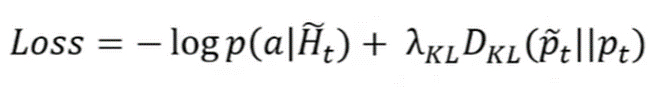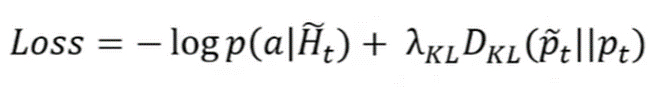

In [52]:
def perturb_past(
    past,
    model,
    last,
    unpert_past=None,
    unpert_logits=None,
    accumulated_hidden=None,
    grad_norms=None,
    stepsize=0.01,
    one_hot_bows_vectors=None,
    classifier=None,
    class_label=None,
    loss_type=0,
    num_iterations=3,
    horizon_length=1,
    window_length=0,
    decay=False,
    gamma=1.5,
    kl_scale=0.01,
    perturb_layer = 100,
    device="cuda",
):
    # Generate inital perturbed past
    qq= []
    for i in range(len(past)):
        qq.append(torch.stack([past[i][0],past[i][1]]))
    past =tuple(qq)
    grad_accumulator = [(np.zeros(p.shape).astype("float32")) for p in past]

    if accumulated_hidden is None:
        accumulated_hidden = 0

    if decay:
        decay_mask = torch.arange(0.0, 1.0 + SMALL_CONST, 1.0 / (window_length))[1:]
    else:
        decay_mask = 1.0

    # TODO fix this comment (SUMANTH)
    # Generate a mask is gradient perturbated is based on a past window
    _, _, _, curr_length, _ = past[0].shape

    if curr_length > window_length and window_length > 0:
        ones_key_val_shape = tuple(past[0].shape[:-2]) + (window_length,) + tuple(past[0].shape[-1:])

        zeros_key_val_shape = tuple(past[0].shape[:-2]) + (curr_length - window_length,) + tuple(past[0].shape[-1:])

        ones_mask = torch.ones(ones_key_val_shape)
        ones_mask = decay_mask * ones_mask.permute(0, 1, 2, 4, 3)
        ones_mask = ones_mask.permute(0, 1, 2, 4, 3)

        window_mask = torch.cat((ones_mask, torch.zeros(zeros_key_val_shape)), dim=-2).to(device)
    else:
        window_mask = torch.ones_like(past[0]).to(device)

    # accumulate perturbations for num_iterations
    loss_per_iter = []
    new_accumulated_hidden = None
    for i in range(num_iterations):
        print("Iteration ", i + 1)

        if perturb_layer == 100:
            curr_perturbation = [torch.from_numpy(p_).requires_grad_(True).to(device=device) for p_ in grad_accumulator]
            # make sure p_.grad is not None
            for p_ in curr_perturbation:
                p_.retain_grad()
        else:
            target_index = 32 + perturb_layer
            curr_perturbation = [torch.from_numpy(p_).requires_grad_(i == target_index).to(device=device) for i, p_ in enumerate(grad_accumulator)]
            # make sure p_.grad is not None
            for i, p_ in enumerate(curr_perturbation):
                if i == target_index:
                    p_.retain_grad()

        # Compute hidden using perturbed past
        perturbed_past = list(map(add, past, curr_perturbation))

        for i in range(len(perturbed_past)):
            perturbed_past[i] = perturbed_past[i].to(torch.float16)

        _, _, _, curr_length, _ = curr_perturbation[0].shape
        lm_output = model(last, past_key_values=perturbed_past,return_dict =True,output_hidden_states=True)
        #print(len(perturbed_past),perturbed_past[0].shape)
        all_logits, all_hidden = lm_output["logits"], lm_output["hidden_states"]
        hidden = all_hidden[-1]
        new_accumulated_hidden = accumulated_hidden + torch.sum(hidden, dim=1).detach()
        # TODO: Check the layer-norm consistency of this with trained discriminator (Sumanth)
        logits = all_logits[:, -1, :]
        probs = nn.functional.softmax(logits, dim=-1)

        loss = 0.0
        loss_list = []
        '''
        if loss_type == PPLM_BOW or loss_type == PPLM_BOW_DISCRIM:
            for one_hot_bow in one_hot_bows_vectors:
                bow_logits = torch.mm(probs, torch.t(one_hot_bow))
                bow_loss = -torch.log(torch.sum(bow_logits))
                loss += bow_loss
                loss_list.append(bow_loss)
            print(" pplm_bow_loss:", loss.data.cpu().numpy())
        '''
        if loss_type == 2 or loss_type == 3:
            ce_loss = nn.CrossEntropyLoss()
            # TODO why we need to do this assignment and not just using unpert_past? (Sumanth)
            curr_unpert_past = unpert_past
            curr_probs = torch.unsqueeze(probs, dim=1)
            wte = model.resize_token_embeddings()
            for _ in range(horizon_length):
                #print(curr_probs)
                #print(wte.weight.data)
                inputs_embeds = torch.matmul(curr_probs, wte.weight.data.float())
                lm_output = model(past_key_values=curr_unpert_past, inputs_embeds=inputs_embeds,return_dict=True,output_hidden_states=True)
                curr_all_logits, curr_unpert_past, curr_all_hidden = (
                    lm_output["logits"],
                    lm_output["past_key_values"],
                    lm_output["hidden_states"],
                )
                curr_logits = curr_all_logits[:, -1, :]
                curr_probs = nn.functional.softmax(curr_logits, dim=-1)
                curr_probs = torch.unsqueeze(curr_probs, dim=1)
                curr_hidden = curr_all_hidden[-1]
                new_accumulated_hidden = new_accumulated_hidden + torch.sum(curr_hidden, dim=1)
            #print(classifier)
            #print(new_accumulated_hidden.shape)
            prediction = classifier(new_accumulated_hidden / (curr_length + 1 + horizon_length))

            label = torch.tensor(prediction.shape[0] * [class_label], device=device, dtype=torch.long)
            discrim_loss = ce_loss(prediction, label)
            print(" pplm_discrim_loss:", discrim_loss.data.cpu().numpy())
            loss += discrim_loss
            loss_list.append(discrim_loss)

        kl_loss = 0.0
        if kl_scale > 0.0:
            unpert_probs = nn.functional.softmax(unpert_logits[:, -1, :], dim=-1)
            unpert_probs = unpert_probs + SMALL_CONST * (unpert_probs <= SMALL_CONST).float().to(device).detach()
            correction = SMALL_CONST * (probs <= SMALL_CONST).float().to(device).detach()
            corrected_probs = probs + correction.detach()
            kl_loss = kl_scale * ((corrected_probs * (corrected_probs / unpert_probs).log()).sum())
            print(" kl_loss", kl_loss.data.cpu().numpy())
            loss += kl_loss

        loss_per_iter.append(loss.data.cpu().numpy())
        print(" pplm_loss", (loss - kl_loss).data.cpu().numpy())

        # compute gradients
        loss.backward()

        # calculate gradient norms
        grad_norms = [
            (torch.norm(p_.grad * window_mask) + SMALL_CONST) for index, p_ in enumerate(curr_perturbation)]

        # normalize gradients
        grad = [
            -stepsize * (p_.grad * window_mask / grad_norms[index] ** gamma).data.cpu().numpy()
            for index, p_ in enumerate(curr_perturbation)]
        
        # accumulate gradient
        grad_accumulator = list(map(add, grad, grad_accumulator))
        
        # reset gradients, just to make sure
        
        for p_ in curr_perturbation:
            p_.grad.data.zero_()

        # removing past from the graph
        new_past = []
        for p_ in past:
            new_past.append(p_.detach())
        past = new_past

    # apply the accumulated perturbations to the past
    grad_accumulator = [torch.from_numpy(p_).requires_grad_(True).to(device=device) for p_ in grad_accumulator]
    pert_past = list(map(add, past, grad_accumulator))
    
    return pert_past, new_accumulated_hidden, grad_norms, loss_per_iter

In [53]:
cond_text = 'I am studying'

raw_text = cond_text
tokenized_cond_text = tokenizer.encode(tokenizer.bos_token + raw_text)

context = tokenized_cond_text

output_so_far = None
past = None
perturb=True
if context:
    context_t = torch.tensor(context, device=device, dtype=torch.long)
    while len(context_t.shape) < 2:
        context_t = context_t.unsqueeze(0)
    output_so_far = context_t # tensor([[    1,   306,   626, 23382]], device='cuda:0')

grad_norms = None
last = None
unpert_discrim_loss = 0
loss_in_time = []
for i in trange(length, ascii=True):
    
    # Get past/probs for current output, except for last word
    # Note that GPT takes 2 inputs: past + current_token

    # run model forward to obtain unperturbed
    if past is None and output_so_far is not None: # 제일 처음에만 얘한테 걸림. 
        
        last = output_so_far[:, -1:] # 마지막 단어
        if output_so_far.shape[1] > 1:
            past = model(output_so_far[:, :-1],return_dict =True)["past_key_values"] # 이전 단어들을 input으로 넣어서 첫 past 만듬. 
            #print(len(past),len(past[0]),past[0][0].shape) #layer수,keyvalue, torch.Size([1, 32, 3, 128]) (batch_size, num_heads, sequence_length, embed_size_per_head)

    lm_output = model(output_so_far,return_dict =True,output_hidden_states=True)
    unpert_logits, unpert_past, unpert_all_hidden = (
        lm_output["logits"], #Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax). #(batch_size, sequence_length, vocab_size)
        lm_output["past_key_values"], # #layer수,keyvalue, (batch_size, num_heads, sequence_length, embed_size_per_head(key 벡터의 길이))
        lm_output["hidden_states"], #layer 수+1, (batch_size, sequence_length, hidden_size(sequence를 이 벡터 길이만큼 표현하겠다)).
    )
    #print(unpert_logits.shape) #(batch_size, sequence_length, config.vocab_size)
    #print(len(unpert_past),len(unpert_past[0]),unpert_past[0][0].shape)
    #print(len(unpert_all_hidden),unpert_all_hidden[0].shape)  33 torch.Size([1, 4, 4096])
    unpert_last_hidden = unpert_all_hidden[-1]
    #print(unpert_last_hidden.shape) #torch.Size([1, 4, 4096])
   
    current_stepsize = stepsize

    # modify the past if necessary
    if not perturb or num_iterations == 0:
        pert_past = past
    
    ####################################### perturb 하는 부분 #################################
    else:
            accumulated_hidden = unpert_last_hidden[:, :-1, :] #torch.Size([1, 3, 4096])
            accumulated_hidden = torch.sum(accumulated_hidden, dim=1) #torch.Size([1, 4096])

            if past is not None:
                pert_past, _, grad_norms, loss_this_iter = perturb_past(
                    past,
                    model,
                    last,
                    unpert_past=unpert_past,
                    unpert_logits=unpert_logits,
                    accumulated_hidden=accumulated_hidden,
                    grad_norms=grad_norms,
                    stepsize=current_stepsize,
                    one_hot_bows_vectors=one_hot_bows_vectors,
                    classifier=classifier,
                    class_label=class_label,
                    loss_type=loss_type,
                    num_iterations=num_iterations,
                    horizon_length=horizon_length,
                    window_length=window_length,
                    decay=decay,
                    gamma=gamma,
                    kl_scale=kl_scale,
                    perturb_layer = perturb_layer,
                    device=device,
                )
                loss_in_time.append(loss_this_iter)
            else:
                pert_past = past         
    ####################################### perturb 하는 부분 끝 #################################
    
    ''' past type 맞춰주기'''
    qqqq= []
    for i in range(len(pert_past)):
        qqqq.append(torch.stack([pert_past[i][0],pert_past[i][1]]))
    pert_past = qqqq
    for i in range(len(pert_past)):
        pert_past[i] = pert_past[i].to(torch.float16)
    '''past type 맞춰주기 끝''' 
    
    #print(last)
    lm_output = model(last, past_key_values=pert_past,return_dict =True,output_hidden_states=True) # 마지막 단어와,past를 input으로 넣음. 
    pert_logits, past = (
        lm_output["logits"], # torch.Size([1, 1, 32000])
        lm_output["past_key_values"],
    )
    #print(pert_logits.shape) #(batch_size, sequence_length=1, config.vocab_size)
    #print(len(past),len(past[0]),past[0][0].shape)
    
    ''' temperatute_scailing, repetition_penalty으로 pert_logits 건드리기'''
    pert_logits = pert_logits[:, -1, :] / temperature  # + SMALL_CONST
    #print(pert_logits.shape) # torch.Size([1, 32000])
    #print(output_so_far[0])
    for token_idx in set(output_so_far[0].tolist()):
        if pert_logits[0, token_idx] < 0:
            pert_logits[0, token_idx] *= repetition_penalty
        else:
            pert_logits[0, token_idx] /= repetition_penalty
    ''' temperatute_scailing, repetition_penalty 끝'''
    
    pert_probs = nn.functional.softmax(pert_logits, dim=-1)
    
    if classifier is not None:
        ce_loss = nn.CrossEntropyLoss()
        # print(torch.mean(unpert_last_hidden, dim=1).shape) # torch.Size([1, 4096])
        prediction = classifier(torch.mean(unpert_last_hidden, dim=1))
        label = torch.tensor([class_label], device=device, dtype=torch.long)
        unpert_discrim_loss = ce_loss(prediction, label)
        print("unperturbed discrim loss", unpert_discrim_loss.data.cpu().numpy())
    else:
        unpert_discrim_loss = 0

    # Fuse the modified model and original model
    if perturb: 
        unpert_probs = nn.functional.softmax(unpert_logits[:, -1, :], dim=-1)

        pert_probs = (pert_probs**gm_scale) * (unpert_probs ** (1 - gm_scale))  # + SMALL_CONST
        pert_probs = top_k_filter(pert_probs, k=top_k, probs=True)  # + SMALL_CONST

        # rescale
        if torch.sum(pert_probs) <= 1:
            pert_probs = pert_probs / torch.sum(pert_probs)
    else:
        pert_logits = top_k_filter(pert_logits, k=top_k)  # + SMALL_CONST
        pert_probs = nn.functional.softmax(pert_logits, dim=-1)

    # sample or greedy
    if sample:
        last = torch.multinomial(pert_probs, num_samples=1)

    else:
        _, last = torch.topk(pert_probs, k=1, dim=-1)

    # update context/output_so_far appending the new token
    output_so_far = last if output_so_far is None else torch.cat((output_so_far, last), dim=1)

    print(tokenizer.decode(output_so_far.tolist()[0]))
    print("$$$$$$$$$$$$")
    print("")

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]

Iteration  1
tensor([[[1.2863e-11, 3.0968e-13, 3.8057e-06,  ..., 2.3708e-10,
          7.1894e-10, 3.0269e-09]]], device='cuda:0',
       grad_fn=<UnsqueezeBackward0>)
tensor([[ 9.8884e-05, -2.3329e-04,  5.8460e-04,  ..., -3.4237e-04,
          5.9724e-05, -1.1957e-04],
        [ 1.5289e-02, -1.2154e-02,  1.2512e-02,  ...,  1.3092e-02,
          7.2174e-03, -6.8045e-04],
        [ 1.7433e-03,  1.7633e-03, -1.4465e-02,  ..., -1.1444e-02,
         -1.2665e-02,  3.7289e-04],
        ...,
        [-9.0179e-03,  3.0807e-02, -1.6708e-02,  ..., -1.2680e-02,
          1.0437e-02,  4.2343e-03],
        [-1.1368e-02, -1.4801e-02, -3.5667e-03,  ...,  6.5308e-03,
         -2.2263e-02, -6.1455e-03],
        [-1.3992e-02,  1.6985e-03, -2.1469e-02,  ...,  1.3527e-02,
          2.8290e-02, -8.9111e-03]], device='cuda:0', dtype=torch.float16)


/home/wooseok/miniconda3/envs/mh/lib/python3.8/site-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
  0%|                                                                                             | 0/5 [00:04<?, ?it/s]


RuntimeError: expected scalar type Float but found Half

In [51]:
a= torch.tensor([[3,4]],dtype=torch.float16)
a.float()

tensor([[3., 4.]])

In [ ]:
# return pert_past, new_accumulated_hidden, grad_norms, loss_per_iter

In [ ]:
lm_output= model(last, past_key_values=past,
                 return_dict=True,output_hidden_states=True)  
logit, past = (
    lm_output["logits"], 
    lm_output["past_key_values"]) 

probs = nn.functional.softmax(logit[:,-1,:], dim=-1)
last = torch.topk(probs, k=1, dim=-1)[1]

In [ ]:


lm_output = model(last, past_key_values=perturbed_past
                  ,return_dict =True)
pert_logits, past = (
    lm_output["logits"],
    lm_output["past_key_values"])
pert_probs = nn.functional.softmax(pert_logits, dim=-1)
pert_last = torch.topk(pert_probs, k=1, dim=-1)[1]

In [12]:
pert_logits.shape

torch.Size([1, 32000])

In [78]:
print(unpert_last_hidden.shape)

torch.Size([1, 8, 4096])


In [79]:
print(accumulated_hidden.shape)

torch.Size([1, 4096])


In [189]:
accumulated_hidden = unpert_last_hidden[:, :-1, :] #torch.Size([1, 3, 4096])
#print(accumulated_hidden.shape)
accumulated_hidden = torch.sum(accumulated_hidden, dim=1) #torch.Size([1, 4096])
#print(accumulated_hidden.shape)

In [89]:
if curr_length > window_length and window_length > 0:
    ones_key_val_shape = tuple(past[0].shape[:-2]) + (window_length,) + tuple(past[0].shape[-1:])

    zeros_key_val_shape = tuple(past[0].shape[:-2]) + (curr_length - window_length,) + tuple(past[0].shape[-1:])

    ones_mask = torch.ones(ones_key_val_shape)
    ones_mask = decay_mask * ones_mask.permute(0, 1, 2, 4, 3)
    ones_mask = ones_mask.permute(0, 1, 2, 4, 3)

    window_mask = torch.cat((ones_mask, torch.zeros(zeros_key_val_shape)), dim=-2).to(device)
else:
    window_mask = torch.ones_like(past[0]).to(device)
decay_mask = 1.0

In [190]:
qq= []
for i in range(len(past)):
    qq.append(torch.stack([past[i][0],past[i][1]]))
past =tuple(qq)
print(len(past),past[0].shape)

32 torch.Size([2, 1, 32, 4, 128])


In [46]:
# Generate inital perturbed past

grad_accumulator = [(np.zeros(p.shape).astype("float32")) for p in past] # 32 (2, 1, 32, 3, 128)

if accumulated_hidden is None:
    accumulated_hidden = 0

# TODO fix this comment (SUMANTH)
# Generate a mask is gradient perturbated is based on a past window
_, _, _, curr_length, _ = past[0].shape

# accumulate perturbations for num_iterations
loss_per_iter = []
new_accumulated_hidden = None

'''grad_accumulator update (델타 H_t update)과정'''
for i in range(num_iterations):
    print("Iteration ", i + 1)

    curr_perturbation = [torch.from_numpy(p_).requires_grad_(True).to(device=device) for p_ in grad_accumulator]
    #numpy에서 tensor로 바꿔주고, requires_grad 켜주고, gpu 올려주고. 
    '''tensor의 gradient를 구할 때에는 다음 조건들이 만족되어야 gradient를 구할 수 있습니다.
        1) tensor의 옵션이 requires_grad = True 로 설정되어 있어야 합니다. (tensor의 기본 값은 requires_grad = False 입니다.)'''
    for p_ in curr_perturbation:
        p_.retain_grad() 
        '''해당 변수에 대한 gradient 연산을 기억 -> 
        이것을 하지 않으면 중간 변수에 대한 gradient는 저장 안됨.
        reatain_grad()를 통해 gradient가 사라지는 것을 예방할 수 있다. 
        계산그래프에서 leaf node가 아닌 tensor의 gradient는 계산 후 날라가는데, 
        retain_grad를 통해 날라가지 않고 붙잡을 수 있다.'''

    # Compute hidden using perturbed past
    
    perturbed_past = list(map(add, past, curr_perturbation))
    #print(len(perturbed_past),perturbed_past[0].shape)
    for i in range(len(perturbed_past)):
        perturbed_past[i] = perturbed_past[i].to(torch.float16)

    _, _, _, curr_length, _ = curr_perturbation[0].shape
    lm_output = model(last, past_key_values=perturbed_past,return_dict =True,output_hidden_states=True)
    
    all_logits, all_hidden = lm_output["logits"], lm_output["hidden_states"] # torch.Size([1, 1, 32000]) , 33 torch.Size([1, 1, 4096])
    print(",ㅇㅂㅈㅂㅈㅂ",all_logits.shape)
    print(len(all_hidden),all_hidden[0].shape)
    hidden = all_hidden[-1]
    new_accumulated_hidden = accumulated_hidden + torch.sum(hidden, dim=1).detach() #torch.Size([1, 4096])
    #여기까지 h_t +h_{t+1}
    
    logits = all_logits[:, -1, :] 
    print(logits.shape)
    probs = nn.functional.softmax(logits, dim=-1)  #p_{t+1}
    
    ######loss 구하기##########
    loss = 0.0
    loss_list = []
    '''1. loss의 첫째항 시작'''
    ce_loss = nn.CrossEntropyLoss()

    curr_unpert_past = unpert_past
    curr_probs = torch.unsqueeze(probs, dim=1)
    wte = model.resize_token_embeddings() #word token embeddings
    
    #print("curr_probs",curr_probs.shape) # torch.Size([1, 1, 32000])
    print(type(curr_probs))
    print(type(wte.weight.data))
    inputs_embeds = torch.matmul(curr_probs, wte.weight.data) # 32000-> 4096
    #print("inputs_embeds",inputs_embeds) 
    #print(inputs_embeds.shape) # torch.Size([1, 1, 4096])
    #curr_unpert_past : H_{t+1}
    # inputs_embeds: x_{t+1} (approximated)
    lm_output = model(past_key_values=curr_unpert_past, inputs_embeds=inputs_embeds,return_dict=True,output_hidden_states=True)
    curr_all_logits, curr_unpert_past, curr_all_hidden = (
        lm_output["logits"], 
        lm_output["past_key_values"], 
        lm_output["hidden_states"], # h_{t+2}
    )
    print("zzzzzzzzzzzzzzzzzzㅋㅋ",curr_all_logits.shape)
    #print(len(curr_unpert_past),len(curr_unpert_past[0]),curr_unpert_past[0][0].shape)

    curr_logits = curr_all_logits[:, -1, :]
    curr_probs = nn.functional.softmax(curr_logits, dim=-1)
    curr_probs = torch.unsqueeze(curr_probs, dim=1) 
    curr_hidden = curr_all_hidden[-1]
    #print(curr_hidden.shape) #torch.Size([1, 1, 4096])
    new_accumulated_hidden = new_accumulated_hidden + torch.sum(curr_hidden, dim=1) # torch.Size([1, 4096])
    #print(classifier)
    print(new_accumulated_hidden.shape,"zzzzzzzzzzzzzzzz")
    
    prediction = classifier(new_accumulated_hidden / (curr_length + 1 + horizon_length))
    print("ㅇㅇ",prediction)
    label = torch.tensor(prediction.shape[0] * [class_label], device=device, dtype=torch.long)
    discrim_loss = ce_loss(prediction, label) # likelihood 
    print(" pplm_discrim_loss:", discrim_loss.data.cpu().numpy())
    loss += discrim_loss
    loss_list.append(discrim_loss)
    '''1. loss의 첫째항 끝'''
    
    '''2. loss의 둘째항 시작'''
    kl_loss = 0.0
    if kl_scale > 0.0:
        unpert_probs = nn.functional.softmax(unpert_logits[:, -1, :], dim=-1)
        unpert_probs = unpert_probs + SMALL_CONST * (unpert_probs <= SMALL_CONST).float().to(device).detach()
        correction = SMALL_CONST * (probs <= SMALL_CONST).float().to(device).detach()
        corrected_probs = probs + correction.detach()
        kl_loss = kl_scale * ((corrected_probs * (corrected_probs / unpert_probs).log()).sum())
        print(" kl_loss", kl_loss.data.cpu().numpy())
        loss += kl_loss
    '''2. loss의 둘째항 끝'''
    
    loss_per_iter.append(loss.data.cpu().numpy())
    #print(" pplm_loss", (loss - kl_loss).data.cpu().numpy())

    # compute gradients
    loss.backward() # gradient 계산 , p_.grad는 gradient 계산값

    # calculate gradient norms
    grad_norms = [
        (torch.norm(p_.grad) + SMALL_CONST) for index, p_ in enumerate(curr_perturbation)]

    # normalize gradients
    grad = [
        -stepsize * (p_.grad  / grad_norms[index] ** gamma).data.cpu().numpy()
        for index, p_ in enumerate(curr_perturbation)]

    # accumulate gradient
    grad_accumulator = list(map(add, grad, grad_accumulator))

    # reset gradients, just to make sure

    for p_ in curr_perturbation:
        p_.grad.data.zero_()

    # removing past from the graph
    new_past = []
    for p_ in past:
        new_past.append(p_.detach())
    past = new_past
'''grad_accumulator update 과정 끝 '''

# apply the accumulated perturbations to the past

grad_accumulator = [torch.from_numpy(p_).requires_grad_(True).to(device=device) for p_ in grad_accumulator]

pert_past = list(map(add, past, grad_accumulator))

AttributeError: 'tuple' object has no attribute 'shape'

In [221]:
grad_accumulator = [(np.zeros(p.shape).astype("float32")) for p in past]
grad_accumulator[0][0][0][0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [222]:
curr_perturbation = [torch.from_numpy(p_).requires_grad_(True).to(device=device) for p_ in grad_accumulator]
curr_perturbation[0][0][0][0][0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0', dtype=torch.float32,
       grad_fn=<SelectBackward0>)

In [206]:
grad_accumulator = [(np.zeros(p.shape).astype("float32")) for p in past]
    
for i in range(num_iterations):
    curr_perturbation = [torch.from_numpy(p_).requires_grad_(True).to(device=device) for p_ in grad_accumulator]
    
    for p_ in curr_perturbation:
        p_.retain_grad() 
    
    # accumulated_hidden_average 구하기
    perturbed_past = list(map(add, past, curr_perturbation))     
    
    _, _, _, curr_length, _ = curr_perturbation[0].shape
    lm_output = model(last, past_key_values=perturbed_past,return_dict =True,output_hidden_states=True)
    
    all_logits, all_hidden = (
        lm_output["logits"], # torch.Size([1, 1, 32000])
        lm_output["hidden_states"])  #33 torch.Size([1, 1, 4096]) h_{t+1}
    
    hidden = all_hidden[-1] 
    new_accumulated_hidden = accumulated_hidden + torch.sum(hidden, dim=1).detach() #torch.Size([1, 4096])
    #여기까지 h_t +h_{t+1}
    
    logits = all_logits[:, -1, :] 
    probs = nn.functional.softmax(logits, dim=-1)  #p_{t+1}
    
    curr_unpert_past = unpert_past
    curr_probs = torch.unsqueeze(probs, dim=1) # torch.Size([1, 1, 32000])
    wte = model.resize_token_embeddings() #word token embeddings # 32000-> 4096
    
    inputs_embeds = torch.matmul(curr_probs, wte.weight.data) # torch.Size([1, 1, 4096])
    
    #curr_unpert_past : H_{t+1}
    # inputs_embeds: x_{t+1} (approximated)
    lm_output = model(past_key_values=curr_unpert_past, inputs_embeds=inputs_embeds,return_dict=True,output_hidden_states=True)
    curr_all_logits, curr_unpert_past, curr_all_hidden = (
        lm_output["logits"], 
        lm_output["past_key_values"], 
        lm_output["hidden_states"]) # h_{t+2} 
    
    curr_hidden = curr_all_hidden[-1] #torch.Size([1, 1, 4096])
    new_accumulated_hidden = new_accumulated_hidden + torch.sum(curr_hidden, dim=1) # torch.Size([1, 4096])
    accumulated_hidden_average = new_accumulated_hidden/(curr_length+1)
    
    #loss 구하기 
    prediction = classifier(accumulated_hidden_average)

    label = torch.tensor(prediction.shape[0] * [class_label], device=device, dtype=torch.long)

    ce_loss = nn.CrossEntropyLoss()
    loss = ce_loss(prediction, label)

    # compute gradients
    loss.backward() # gradient 계산 , p_.grad는 gradient 계산값

    # calculate gradient norms
    grad_norms = [(torch.norm(p_.grad) + SMALL_CONST) for index, p_ in enumerate(curr_perturbation)]
    
    # normalize gradients
    grad = [-stepsize * (p_.grad  / grad_norms[index] ** gamma).data.cpu().numpy()
        for index, p_ in enumerate(curr_perturbation)]

    # accumulate gradient
    grad_accumulator = list(map(add, grad, grad_accumulator))


pert_past = list(map(add, past, grad_accumulator))

[tensor(0.0557, device='cuda:0', dtype=torch.float32),
 tensor(0.0478, device='cuda:0', dtype=torch.float32),
 tensor(0.0780, device='cuda:0', dtype=torch.float32),
 tensor(0.1556, device='cuda:0', dtype=torch.float32),
 tensor(0.1485, device='cuda:0', dtype=torch.float32),
 tensor(0.1387, device='cuda:0', dtype=torch.float32),
 tensor(0.1226, device='cuda:0', dtype=torch.float32),
 tensor(0.1126, device='cuda:0', dtype=torch.float32),
 tensor(0.0964, device='cuda:0', dtype=torch.float32),
 tensor(0.0919, device='cuda:0', dtype=torch.float32),
 tensor(0.0902, device='cuda:0', dtype=torch.float32),
 tensor(0.1007, device='cuda:0', dtype=torch.float32),
 tensor(0.1021, device='cuda:0', dtype=torch.float32),
 tensor(0.1069, device='cuda:0', dtype=torch.float32),
 tensor(0.0972, device='cuda:0', dtype=torch.float32),
 tensor(0.1018, device='cuda:0', dtype=torch.float32),
 tensor(0.1016, device='cuda:0', dtype=torch.float32),
 tensor(0.0983, device='cuda:0', dtype=torch.float32),
 tensor(0.

In [239]:
len(curr_all_hidden)

33

In [226]:
perturb_layer =11
list(range(perturb_layer-11,perturb_layer))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [233]:
torch.sum(curr_hidden, dim=1)

tensor([[-0.0538, -1.0723,  0.2404,  ...,  0.8218,  2.9785,  2.0508]],
       device='cuda:0', grad_fn=<SumBackward1>)

In [234]:
curr_hidden

tensor([[[-0.0538, -1.0723,  0.2404,  ...,  0.8218,  2.9785,  2.0508]]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [223]:
grad_accumulator = [(np.zeros(p.shape).astype("float32")) for p in past]

target_index = list(range(0,11))
for i in range(num_iterations):
    curr_perturbation = [torch.from_numpy(p_).requires_grad_(i in target_index).to(device=device) for i, p_ in enumerate(grad_accumulator)]
    
    for i, p_ in enumerate(curr_perturbation):
        if i in target_index:
            p_.retain_grad()
    
    # accumulated_hidden_average 구하기
    perturbed_past = list(map(add, past, curr_perturbation))     
    '''
    ...........................
    '''
    
    prediction = classifier(accumulated_hidden_average)

    label = torch.tensor(prediction.shape[0] * [class_label], device=device, dtype=torch.long)

    ce_loss = nn.CrossEntropyLoss()
    loss = ce_loss(prediction, label)

    # compute gradients
    loss.backward() # gradient 계산 , p_.grad는 gradient 계산값

    # calculate gradient norms
    grad_norms = [(torch.norm(p_.grad * window_mask) + SMALL_CONST) if index in target_index 
                  else SMALL_CONST for index, p_ in enumerate(curr_perturbation)]

    # normalize gradients
    grad = [-stepsize * (p_.grad * window_mask / grad_norms[index] ** gamma).data.cpu().numpy() if index in target_index 
            else np.zeros_like(p_.cpu())
        for index, p_ in enumerate(curr_perturbation)]

    # accumulate gradient
    grad_accumulator = list(map(add, grad, grad_accumulator))

pert_past = list(map(add, past, grad_accumulator))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:21                                                                                   │
│                                                                                                  │
│   18 │   '                                                                                       │
│   19 │   '''                                                                                     │
│   20 │                                                                                           │
│ ❱ 21 │   prediction = classifier(accumulated_hidden_average)                                     │
│   22 │                                                                                           │
│   23 │   label = torch.tensor(prediction.shape[0] * [class_label], device=device, dtype=torch    │
│   24                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'accumulated_hidden_average' is not defined

In [208]:
grad_norms = [torch.norm(p_.grad) for index, p_ in enumerate(curr_perturbation)]
grad_norms

[tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dtype=torch.float32),
 tensor(0., device='cuda:0', dt

In [48]:
grad_norms = [
        (torch.norm(p_.grad * window_mask) + SMALL_CONST) for index, p_ in enumerate(curr_perturbation)]

In [50]:
grad_norms_m = [
        (torch.norm(p_.grad) + SMALL_CONST) for index, p_ in enumerate(curr_perturbation)]

In [108]:
print(p_.grad)

None


In [111]:
p_.grad  / grad_norms[0] ** gamma

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 p_.grad  / grad_norms[0] ** gamma                                                            │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: unsupported operand type(s) for /: 'NoneType' and 'Tensor'

In [22]:
torch.tensor([class_label], device=device, dtype=torch.long)

tensor([2], device='cuda:0')

In [44]:
window_mask

tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          ...,

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           

In [42]:
perturbed_past = list(map(add, past, curr_perturbation))

In [57]:
torch.sum(curr_hidden, dim=1).shape

torch.Size([1, 4096])

In [44]:
perturbed_past[0].shape

torch.Size([2, 1, 32, 3, 128])

In [64]:
loss

tensor(3.7582, device='cuda:0', grad_fn=<AddBackward0>)

In [49]:
for i in range(len(perturbed_past)):
        perturbed_past[i] = perturbed_past[i].to(torch.float16)
lm_output = model(last, past_key_values=perturbed_past,return_dict =True,output_hidden_states=True)

all_logits, all_hidden = lm_output["logits"], lm_output["hidden_states"]
print(all_logits.shape)


torch.Size([1, 1, 32000])


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│   4                                                                                              │
│   5 all_logits, all_hidden = lm_output["logits"], lm_output["hidden_states"]                     │
│   6 print(all_logits.shape)                                                                      │
│ ❱ 7 print(all_hidden.shape)                                                                      │
│   8                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'tuple' object has no attribute 'shape'

In [50]:
print(len(all_hidden),all_hidden[0].shape)

33 torch.Size([1, 1, 4096])


In [51]:
hidden = all_hidden[-1]
a= torch.sum(hidden, dim=1)
a.shape

torch.Size([1, 4096])

In [ ]:

hidden = all_hidden[-1]
new_accumulated_hidden = accumulated_hidden + torch.sum(hidden, dim=1).detach()
# TODO: Check the layer-norm consistency of this with trained discriminator (Sumanth)
logits = all_logits[:, -1, :]
probs = nn.functional.softmax(logits, dim=-1)


In [52]:
horizon_length

1

In [59]:
curr_length + 1 + horizon_length

5

In [60]:
new_accumulated_hidden/5

tensor([[-2.4238,  3.9180, -3.2617,  ..., -2.1250,  4.5234,  8.4609]],
       device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)

In [61]:
new_accumulated_hidden.shape

torch.Size([1, 4096])

In [62]:
new_accumulated_hidden/10

tensor([[-0.2424,  0.3918, -0.3262,  ..., -0.2125,  0.4524,  0.8462]],
       device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)

In [63]:
kl_scale

0.01

In [42]:
torch.tensor(prediction.shape[0] * [class_label], device=device, dtype=torch.long)

tensor([2], device='cuda:0')